<a href="https://colab.research.google.com/github/sulaimangm/SEP769_CPS_DeepLearning/blob/main/SEP769_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Kaggle

In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


# Import and Extract Dataset

In [2]:
# Download the wildfire prediction dataset
!kaggle datasets download -d garystafford/environmental-sensor-data-132k

# Unzip the downloaded dataset
!unzip environmental-sensor-data-132k.zip

 74% 5.00M/6.74M [00:00<00:00, 32.7MB/s]
100% 6.74M/6.74M [00:00<00:00, 42.4MB/s]
Archive:  environmental-sensor-data-132k.zip
  inflating: iot_telemetry_data.csv  


In [3]:
import zipfile

# Set the path to the zip file
zip_file_path = '/content/environmental-sensor-data-132k.zip'

# Set the path to the directory where the contents of the zip file will be extracted
extract_path = '/content/environmental-sensor-data-132k'

# Extract the contents of the zip file to the extract directory
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Import Libraries

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import numpy as np

# Dataset Pre Processing

In [5]:
dataset_path = '/content/iot_telemetry_data.csv'
df = pd.read_csv(dataset_path)
df.head()

,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000


## Encoding device and Light Values

In [6]:
columns_to_encode = ['device', 'light']
encoder = LabelEncoder()
encoded_df = df.copy()
encoded_df[columns_to_encode] = encoded_df[columns_to_encode].apply(lambda col: encoder.fit_transform(col))
encoded_df.head()

,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,1.594512e+09,2,0.004956,51.000000,0,0.007651,False,0.020411,22.700000
1,1.594512e+09,0,0.002840,76.000000,0,0.005114,False,0.013275,19.700001
2,1.594512e+09,2,0.004976,50.900000,0,0.007673,False,0.020475,22.600000
3,1.594512e+09,1,0.004403,76.800003,1,0.007023,False,0.018628,27.000000
4,1.594512e+09,2,0.004967,50.900000,0,0.007664,False,0.020448,22.600000


## Dropping Unwanted columns

In [7]:
classes = encoded_df['device']
cleaned_df = encoded_df.drop(columns=['ts', 'motion', 'device'])
cleaned_df.head()

,co,humidity,light,lpg,smoke,temp
0,0.004956,51.000000,0,0.007651,0.020411,22.700000
1,0.002840,76.000000,0,0.005114,0.013275,19.700001
2,0.004976,50.900000,0,0.007673,0.020475,22.600000
3,0.004403,76.800003,1,0.007023,0.018628,27.000000
4,0.004967,50.900000,0,0.007664,0.020448,22.600000


## Scaling Data


In [8]:
columns_to_scale = ['co', 'humidity', 'lpg', 'smoke', 'temp']
scaler = StandardScaler()
scaled_df = cleaned_df.copy()
scaled_df[columns_to_scale] = scaler.fit_transform(scaled_df[columns_to_scale])
scaled_df.head()

,co,humidity,light,lpg,smoke,temp
0,0.253670,-0.836820,0,0.286471,0.280867,0.091172
1,-1.438976,1.362631,0,-1.469927,-1.465637,-1.020621
2,0.269729,-0.845618,0,0.301986,0.296495,0.054112
3,-0.188651,1.433013,1,-0.148041,-0.155499,1.684742
4,0.262810,-0.845618,0,0.295303,0.289763,0.054112


In [9]:
classes

0         2
1         0
2         2
3         1
4         2
         ..
405179    0
405180    2
405181    1
405182    0
405183    2
Name: device, Length: 405184, dtype: int64

# Train-Test Split

In [10]:
XTrain,XTest,XcTrain,XcTest=train_test_split(scaled_df,classes,test_size=0.25)

# Classification Using K Nearest Neighbours

## Performing Classification Without Tuning Parameters

In [11]:
knnNonTune = KNeighborsClassifier()
knnNonTune.fit(XTrain,XcTrain)

KNeighborsClassifier()

In [12]:
knn_predictions = knnNonTune.predict(XTest)
knn_test_accuracy = accuracy_score(XcTest, knn_predictions)
print("The Accuracy on the Test Set before Hyper Parameter Tuning is: ", knn_test_accuracy)

The Accuracy on the Test Set before Hyper Parameter Tuning is:  0.9999506397093666


## Performing K-Fold Cross Validation with Parameter Selection using Grid-Search

In [14]:
kList = list(range(1,50))
knn = KNeighborsClassifier()
knn_params = {'n_neighbors' : kList}
grid_kn = GridSearchCV(estimator = knn, param_grid = knn_params, scoring = 'accuracy', cv = 10, verbose = 2, n_jobs=-1)
grid_kn.fit(XTrain, XcTrain)

Fitting 10 folds for each of 49 candidates, totalling 490 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy', verbose=2)

In [15]:
# Get the best KNN model from the grid search
best_knn_model = grid_kn.best_estimator_

# Make predictions on the test set
knn_predictions = best_knn_model.predict(XTest)

# Calculate accuracy on the test set
knn_test_accuracy = accuracy_score(XcTest, knn_predictions)
print("KNN Test Set Accuracy:", knn_test_accuracy)

# Get the best hyperparameters
best_params = grid_kn.best_params_
print("Best Hyperparameters:", best_params)

KNN Test Set Accuracy: 0.9999802558837466
Best Hyperparameters: {'n_neighbors': 1}


## Plotting the graph of no. of Neighbours vs Accuracy

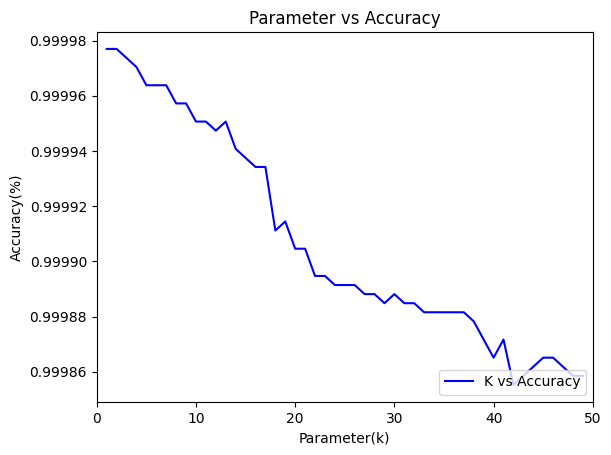

In [16]:
plt.title('Parameter vs Accuracy')
plt.plot(kList, grid_kn.cv_results_['mean_test_score'], 'b', label = 'K vs Accuracy')
plt.legend(loc = 'lower right')
plt.xlim([0, 50])
plt.ylabel('Accuracy(%)')
plt.xlabel('Parameter(k)')
plt.show()

### Confusion Matrix

Confusion Matrix:
[[27876     1     0]
 [    1 26346     0]
 [    0     0 47072]]


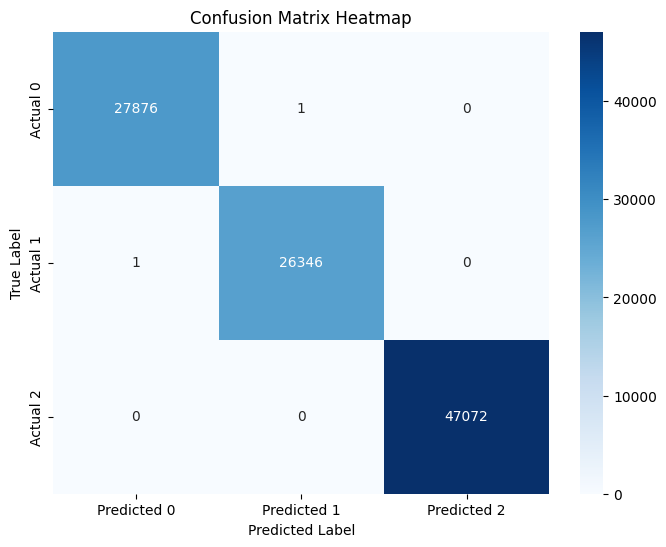

In [17]:
conf_matrix = confusion_matrix(XcTest, knn_predictions)

print("Confusion Matrix:")
print(conf_matrix)

# Create a DataFrame from the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1', 'Actual 2'], columns=['Predicted 0', 'Predicted 1', 'Predicted 2'])

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Classification Report

In [18]:
report = classification_report(XcTest, knn_predictions)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27877
           1       1.00      1.00      1.00     26347
           2       1.00      1.00      1.00     47072

    accuracy                           1.00    101296
   macro avg       1.00      1.00      1.00    101296
weighted avg       1.00      1.00      1.00    101296



# Classification Using Random Forest

## Performing Classification Without Tuning Parameters

In [11]:
rfNonTune = RandomForestClassifier(random_state=0, max_depth=1)
rfNonTune.fit(XTrain,XcTrain)

RandomForestClassifier(max_depth=1, random_state=0)

In [12]:
prediction = rfNonTune.predict(XTest)
test_accuracy = accuracy_score(XcTest, prediction)
print("The Accuracy on the Test Set before Hyper Parameter Tuning is: ", test_accuracy)

The Accuracy on the Test Set before Hyper Parameter Tuning is:  0.9579943926709841


## Performing K-Fold Cross Validation with Parameter Selection using Grid-Search

In [13]:
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier()

grid_rf = GridSearchCV(estimator=rf, param_grid=rf_params, scoring='accuracy', cv=10, verbose=2, n_jobs=1)

# Fit the GridSearchCV on the training data
grid_rf.fit(XTrain, XcTrain)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] END ....................max_depth=None, n_estimators=50; total time=   8.5s
[CV] END ....................max_depth=None, n_estimators=50; total time=   8.4s
[CV] END ....................max_depth=None, n_estimators=50; total time=   8.9s
[CV] END ....................max_depth=None, n_estimators=50; total time=   8.1s
[CV] END ....................max_depth=None, n_estimators=50; total time=   9.6s
[CV] END ....................max_depth=None, n_estimators=50; total time=   8.8s
[CV] END ....................max_depth=None, n_estimators=50; total time=   8.4s
[CV] END ....................max_depth=None, n_estimators=50; total time=   9.3s
[CV] END ....................max_depth=None, n_estimators=50; total time=   9.3s
[CV] END ....................max_depth=None, n_estimators=50; total time=   9.0s
[CV] END ...................max_depth=None, n_estimators=100; total time=  16.9s
[CV] END ...................max_depth=None, n_es

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'max_depth': [None, 10], 'n_estimators': [50, 100]},
             scoring='accuracy', verbose=2)

In [14]:
# Get the best Random Forest model from the grid search
best_rf_model = grid_rf.best_estimator_

# Make predictions on the test set
rf_predictions = best_rf_model.predict(XTest)

# Calculate accuracy on the test set
rf_test_accuracy = accuracy_score(XcTest, rf_predictions)
print("Random Forest Test Set Accuracy:", rf_test_accuracy)

# Get the best hyperparameters
best_params = grid_rf.best_params_
print("Best Hyperparameters:", best_params)

Random Forest Test Set Accuracy: 1.0
Best Hyperparameters: {'max_depth': None, 'n_estimators': 50}


### Confusion Matrix

Confusion Matrix:
[[28109     0     0]
 [    0 26400     0]
 [    0     0 46787]]


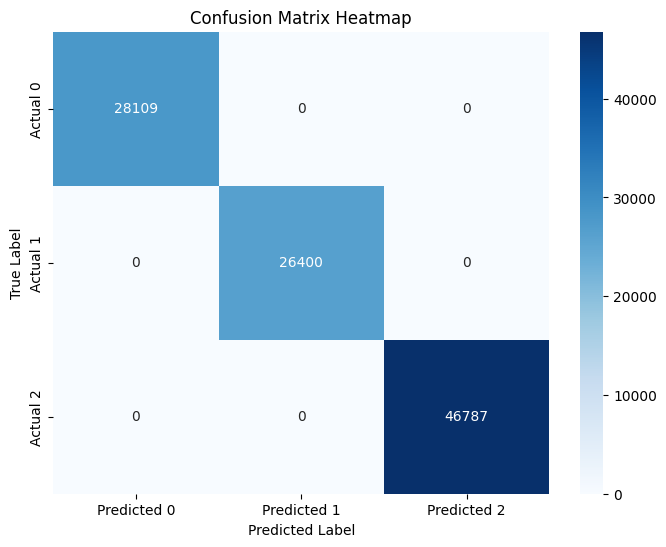

In [15]:
conf_matrix = confusion_matrix(XcTest, rf_predictions)

print("Confusion Matrix:")
print(conf_matrix)

# Create a DataFrame from the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1', 'Actual 2'], columns=['Predicted 0', 'Predicted 1', 'Predicted 2'])

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Classification Report

In [16]:
report = classification_report(XcTest, rf_predictions)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28109
           1       1.00      1.00      1.00     26400
           2       1.00      1.00      1.00     46787

    accuracy                           1.00    101296
   macro avg       1.00      1.00      1.00    101296
weighted avg       1.00      1.00      1.00    101296



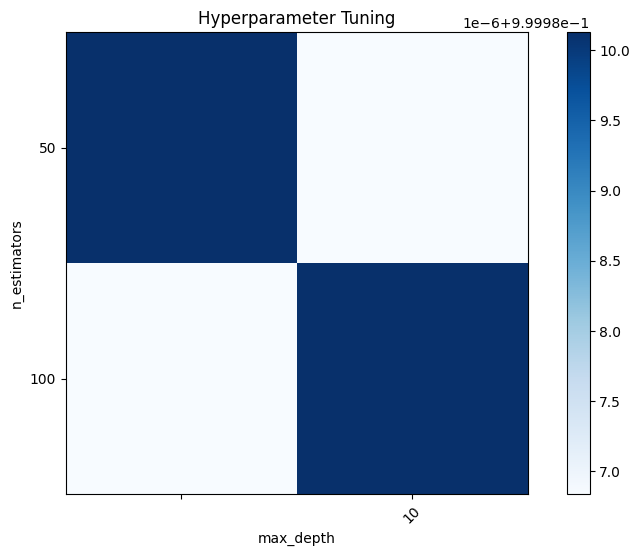

In [17]:
# Extract results from the GridSearchCV object
results = grid_rf.cv_results_
param_names = list(rf_params.keys())
param_values = [rf_params[name] for name in param_names]

# Create a heatmap to visualize the grid search results
scores = np.array(results['mean_test_score']).reshape(len(param_values[0]), len(param_values[1]))
plt.figure(figsize=(10, 6))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Hyperparameter Tuning')
plt.xlabel(param_names[1])
plt.ylabel(param_names[0])
plt.colorbar()
plt.xticks(np.arange(len(param_values[1])), param_values[1], rotation=45)
plt.yticks(np.arange(len(param_values[0])), param_values[0])
plt.show()